In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics, preprocessing
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import gc, math, pickle, datetime, os, random
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import pyplot,dates
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')
import gc

In [3]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams

#import plotly.plotly as py



import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
#print(os.listdir("../input"))

In [4]:
weather_train=pd.read_csv('C:/Users/SGAUR/Desktop/Asphare/ashrae-energy-prediction/weather_train.csv')
train=pd.read_csv('C:/Users/SGAUR/Desktop/Asphare/ashrae-energy-prediction/train.csv')

building_meta = pd.read_csv('C:/Users/SGAUR/Desktop/Asphare/ashrae-energy-prediction/building_metadata.csv')
weather_test=pd.read_csv('C:/Users/SGAUR/Desktop/Asphare/ashrae-energy-prediction/weather_test.csv')
test=pd.read_csv('C:/Users/SGAUR/Desktop/Asphare/ashrae-energy-prediction/test.csv')

In [5]:
print('Shape of Weather Train',weather_train.shape)
print('Shape of Weather Test',weather_test.shape)

Shape of Weather Train (139773, 9)
Shape of Weather Test (277243, 9)


In [6]:
print('Size of train data', train.shape)
print('Size of weather_train data', weather_train.shape)
print('Size of building_meta data', building_meta.shape)
print('Size of test data', test.shape)
print('Size of weather_test data', weather_test.shape)

Size of train data (20216100, 4)
Size of weather_train data (139773, 9)
Size of building_meta data (1449, 6)
Size of test data (41697600, 4)
Size of weather_test data (277243, 9)


In [7]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
train=reduce_mem_usage(train, verbose=True)
weather_train=reduce_mem_usage(weather_train, verbose=True)
building_meta=reduce_mem_usage(building_meta, verbose=True)

test=reduce_mem_usage(test, verbose=True)
weather_test=reduce_mem_usage(weather_test, verbose=True)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


In [9]:
%%time
import gc
print('*********Combining train data*********')
train = train.merge(building_meta, left_on = "building_id", right_on = "building_id", how = "left")
train = train.merge(weather_train, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"],how="left")
print('train shape',train.shape)
del weather_train

print('*********Combining test data*********')
test = test.merge(building_meta, left_on = "building_id", right_on = "building_id", how = "left")
test = test.merge(weather_test, left_on = ["site_id", "timestamp"], right_on = ["site_id", "timestamp"],how="left")
print('test shape',test.shape)
del weather_test


*********Combining train data*********
train shape (20216100, 16)
*********Combining test data*********
test shape (41697600, 16)
Wall time: 27.2 s


In [10]:
%%time
from datetime import date
print('Changing variables in Train Data..')
train["timestamp"] = pd.to_datetime(train["timestamp"])
train["weekday"] = train["timestamp"].dt.weekday
train["hour"] = train["timestamp"].dt.hour
train["weekday"] = train['weekday'].astype(np.uint8)
train["DayNumber"]=train["timestamp"].dt.day
train["hour"] = train['hour'].astype(np.uint8)
train["month"] = train['timestamp'].dt.month
train['Age_of_Building']=date.today().year-train.year_built ## Extra Columns
del train['year_built']
print('..Done')

print('Changing variables in test Data..')
test["timestamp"] = pd.to_datetime(test["timestamp"])
test["weekday"] = test["timestamp"].dt.weekday
test["hour"] = test["timestamp"].dt.hour
test["weekday"] = test['weekday'].astype(np.uint8)
test["DayNumber"]=test["timestamp"].dt.day
test["hour"] = test['hour'].astype(np.uint8)
test["month"] = test['timestamp'].dt.month
test['Age_of_Building']=date.today().year-test.year_built ## Extra Columns
del test['year_built']
print('..Done')
gc.collect()

Changing variables in Train Data..
..Done
Changing variables in test Data..
..Done
Wall time: 25.5 s


56

In [11]:
%%time
## Changing train cat_vars
train['building_id'] = 'building_id_' + train['building_id'].astype(str)
train['month'] = train['month'].map({1: 'Jan', 2: 'Feb',3:'March',4:'April',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct'
                   ,11:'Nov',12:'Dec'})
train['meter']=train['meter'].map({0: 'electricity', 1: 'chilledwater',2:'steam',3:'hotwater'})
train['weekday']=train['weekday'].map({0: 'Monday', 1: 'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})

## Changing test cat_vars
test['building_id'] = 'building_id_' + test['building_id'].astype(str)
test['month'] = test['month'].map({1: 'Jan', 2: 'Feb',3:'March',4:'April',5:'May',6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct'
                   ,11:'Nov',12:'Dec'})
test['meter']=test['meter'].map({0: 'electricity', 1: 'chilledwater',2:'steam',3:'hotwater'})
test['weekday']=test['weekday'].map({0: 'Monday', 1: 'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})

Wall time: 45.3 s


In [12]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,weekday,hour,DayNumber,month,Age_of_Building
0,building_id_0,electricity,2016-01-01,0.0,0,Education,7432,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Friday,0,1,Jan,11.0
1,building_id_1,electricity,2016-01-01,0.0,0,Education,2720,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Friday,0,1,Jan,15.0
2,building_id_2,electricity,2016-01-01,0.0,0,Education,5376,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Friday,0,1,Jan,28.0
3,building_id_3,electricity,2016-01-01,0.0,0,Education,23685,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Friday,0,1,Jan,17.0
4,building_id_4,electricity,2016-01-01,0.0,0,Education,116607,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,Friday,0,1,Jan,44.0


In [20]:
print('Changing meter reading into log inverse')
train["meter_reading"] = np.log1p(train["meter_reading"])
print('Scaling Target variable')
max_value =  np.max(train["meter_reading"])
print('max_value',max_value)
train["meter_reading"] = train["meter_reading"]/np.max(train["meter_reading"]) ## dividing by max value to get 0--1 range

Changing meter reading into log inverse
Scaling Target variable


In [52]:
train["meter_reading"] * np.max(train["meter_reading"])

0           0.000000
1           0.000000
2           0.000000
3           0.000000
4           0.000000
              ...   
20216095    0.411453
20216096    0.352180
20216097    0.000000
20216098    0.625597
20216099    0.295881
Name: meter_reading, Length: 20216100, dtype: float64

In [54]:
np.max(train["meter_reading"] * np.max(train["meter_reading"]))

1.0

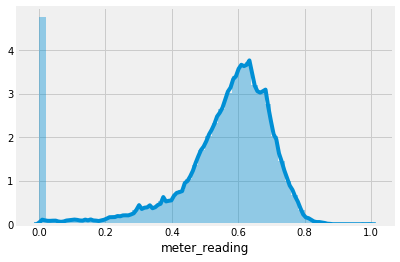

In [21]:
sns.distplot(train["meter_reading"])

In [23]:
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_data

,Total,Percent
floor_count,16709167,82.652772
Age_of_Building,12127645,59.990033
cloud_coverage,8825365,43.655131
precip_depth_1_hr,3749023,18.544739
wind_direction,1449048,7.167792
sea_level_pressure,1231669,6.092515
wind_speed,143676,0.710701
dew_temperature,100140,0.495348
air_temperature,96658,0.478124
primary_use,0,0.000000


In [24]:
%%time

target = 'meter_reading'

cont_vars = ['square_feet','floor_count','air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr',
             'sea_level_pressure','wind_direction','wind_speed','hour','Age_of_Building']

cat_vars = ['building_id','meter','primary_use' ,'month','weekday']

## Columns which No use timestamp became index , remove site_id

## Filling data with zero
train[cont_vars] = train[cont_vars].fillna(value=0)
test[cont_vars] = test[cont_vars].fillna(value=0)

Wall time: 8.53 s


In [25]:
from sklearn.preprocessing import LabelEncoder,StandardScaler
encoders = {}
for v in cat_vars:
    le = LabelEncoder()
    le.fit(train[v].values)
    le.fit(test[v].values)
    encoders[v] = le
    train.loc[:, v] = le.transform(train[v].values)
    test.loc[:, v] = le.transform(test[v].values)
    print('{0}: {1}'.format(v, le.classes_))

building_id: ['building_id_0' 'building_id_1' 'building_id_10' ... 'building_id_997'
 'building_id_998' 'building_id_999']
meter: ['chilledwater' 'electricity' 'hotwater' 'steam']
primary_use: ['Education' 'Entertainment/public assembly' 'Food sales and service'
 'Healthcare' 'Lodging/residential' 'Manufacturing/industrial' 'Office'
 'Other' 'Parking' 'Public services' 'Religious worship' 'Retail'
 'Services' 'Technology/science' 'Utility' 'Warehouse/storage']
month: ['April' 'Aug' 'Dec' 'Feb' 'Jan' 'July' 'June' 'March' 'May' 'Nov' 'Oct'
 'Sep']
weekday: ['Friday' 'Monday' 'Saturday' 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']


In [26]:
%time
## Standralize cont variables Train
scalar=StandardScaler()
scalar.fit(train[cont_vars].values.reshape(-1, train[cont_vars].shape[1]))
train[cont_vars]=scalar.transform(train[cont_vars].values.reshape(-1, train[cont_vars].shape[1]))

print('..Done')
## Standralize cont variables test
scalar=StandardScaler()
scalar.fit(test[cont_vars].values.reshape(-1, test[cont_vars].shape[1]))
test[cont_vars]=scalar.transform(test[cont_vars].values.reshape(-1, test[cont_vars].shape[1]))
print('..Done')
##########################################

print('preproc is to convert dataframe into lists')
features = cont_vars + cat_vars
def preproc(df):
    input_list_train = list()
    
    for i_x in cat_vars:
        input_list_train.append(df[i_x].values)
    
    input_list_train.append(df[cont_vars].values)
    return input_list_train

Wall time: 0 ns
..Done
..Done
preproc is to convert dataframe into lists


In [27]:
for cv in train[cat_vars]:
    categorical_emb_name= cv+'_Embedding'
    no_of_unique_cat  = train[cv].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
    print('Categorica Variable:', cv,'Unique Categories:', no_of_unique_cat,
        'Embedding Size:', embedding_size)

Categorica Variable: building_id Unique Categories: 1449 Embedding Size: 50
Categorica Variable: meter Unique Categories: 4 Embedding Size: 2
Categorica Variable: primary_use Unique Categories: 16 Embedding Size: 8
Categorica Variable: month Unique Categories: 12 Embedding Size: 6
Categorica Variable: weekday Unique Categories: 7 Embedding Size: 4


In [28]:
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation, BatchNormalization, Concatenate
from keras.layers import Dropout, Dense, Input, Reshape
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape, Embedding
from keras.layers import Input

from sklearn.model_selection import StratifiedKFold


def build_embedding_network():
    
    inputs=[]
    output_embeddings=[]
    
    ## building_id
    input_building_id  = Input(shape=(1,))
    output_building_id = Embedding (train['building_id'].nunique(),50,name = "Embedding_Building_id") (input_building_id)
    output_building_id = Reshape(target_shape = (50,))(output_building_id)
    
    ## meter
    input_meter = Input(shape=(1,))
    output_meter = Embedding (train['meter'].nunique(),2,name = "Embedding_meter") (input_meter)
    output_meter = Reshape(target_shape = (2,))(output_meter)
    
    ## primary_use
    input_primary_use = Input(shape=(1,))
    output_primary_use = Embedding (train['primary_use'].nunique(),8,name = "Embedding_primary_use") (input_primary_use)
    output_primary_use = Reshape(target_shape = (8,))(output_primary_use)
    
    ## month
    input_month = Input(shape=(1,))
    output_month = Embedding (train['month'].nunique(),6,name = "Embedding_month") (input_month)
    output_month = Reshape(target_shape = (6,))(output_month)
    
    ## weekday
    input_weekday = Input(shape=(1,))
    output_weekday = Embedding (train['weekday'].nunique(),4,name = "Embedding_weekday") (input_weekday)
    output_weekday = Reshape(target_shape = (4,))(output_weekday)
    
     
    inputs = [input_building_id,input_meter,input_primary_use,input_month,input_weekday]
    
    output_embeddings = [output_building_id, output_meter, output_primary_use, output_month,output_weekday]
    
    input_numeric = Input(shape=(len(cont_vars),))
    numeric_modeling = Dense(256)(input_numeric)
    inputs.append(input_numeric)
    output_embeddings.append(numeric_modeling)
    
    x = Concatenate()(output_embeddings)
    
    x = Dense(512,activation='relu', kernel_initializer='uniform')(x)    
    x = Dropout(0.15)(x)
   # x = BatchNormalization(axis=-1, center=True, scale=False) (x)
    
    x = Dense(512,activation='relu', kernel_initializer='uniform')(x)
    x = Dropout(0.1)(x)
   # x = BatchNormalization(axis=-1, center=True, scale=False)(x)
    
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=x)    
    return model

Using TensorFlow backend.


#### Train-Test Split

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train[cont_vars+cat_vars],train[target],
                                                    test_size=0.2,shuffle=True,random_state=101)

In [33]:
                               
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import gc


X_train =preproc(X_train)
y_train = np.array(y_train)

X_test =preproc(X_test)
y_test = np.array(y_test)

model=build_embedding_network()
opt = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])
## monitoring the job
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto',restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3,
                               verbose=1, mode='auto', min_delta=10, cooldown=0,
                               min_lr=0.0001)
history=model.fit(X_train,y_train, epochs=15, batch_size=4096, validation_data=(X_test, y_test), verbose=1,callbacks=[monitor])


Train on 16172880 samples, validate on 4043220 samples
Epoch 1/15
  827392/16172880 [>.............................] - ETA: 1:27:10 - loss: 0.0455 - mse: 0.04 - ETA: 47:25 - loss: 0.0440 - mse: 0.0440 - ETA: 34:00 - loss: 0.0430 - mse: 0.04 - ETA: 27:23 - loss: 0.0427 - mse: 0.04 - ETA: 23:23 - loss: 0.0422 - mse: 0.04 - ETA: 20:36 - loss: 0.0417 - mse: 0.04 - ETA: 19:00 - loss: 0.0416 - mse: 0.04 - ETA: 17:48 - loss: 0.0416 - mse: 0.04 - ETA: 16:55 - loss: 0.0414 - mse: 0.04 - ETA: 16:09 - loss: 0.0412 - mse: 0.04 - ETA: 15:28 - loss: 0.0410 - mse: 0.04 - ETA: 14:51 - loss: 0.0410 - mse: 0.04 - ETA: 14:21 - loss: 0.0408 - mse: 0.04 - ETA: 13:55 - loss: 0.0406 - mse: 0.04 - ETA: 13:31 - loss: 0.0405 - mse: 0.04 - ETA: 13:10 - loss: 0.0404 - mse: 0.04 - ETA: 12:48 - loss: 0.0404 - mse: 0.04 - ETA: 12:30 - loss: 0.0403 - mse: 0.04 - ETA: 12:18 - loss: 0.0403 - mse: 0.04 - ETA: 12:06 - loss: 0.0401 - mse: 0.04 - ETA: 11:52 - loss: 0.0401 - mse: 0.04 - ETA: 11:38 - loss: 0.0399 - mse: 0.03

In [34]:
from sklearn.decomposition import PCA

def plot_embedding(model, encoders, category_embedding,category):
    embedding_layer = model.get_layer(category_embedding)
    weights = embedding_layer.get_weights()[0]
    pca = PCA(n_components=2)
    weights = pca.fit_transform(weights)
    weights_t = weights.T
    fig, ax = plt.subplots(figsize=(8, 8 * 3 / 4))
    ax.scatter(weights_t[0], weights_t[1])
    for i, day in enumerate(encoders[category].classes_):
        ax.annotate(day, (weights_t[0, i], weights_t[1, i]))
        fig.tight_layout()

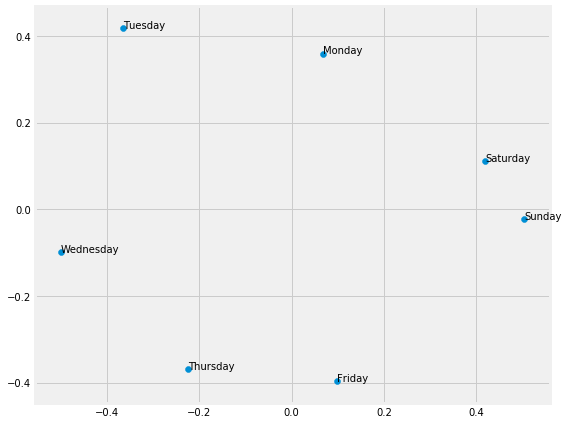

In [35]:
plot_embedding(model, encoders, 'Embedding_weekday','weekday')

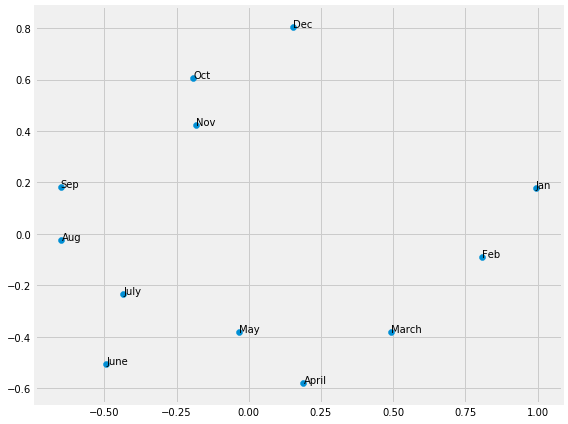

In [36]:
plot_embedding(model, encoders,'Embedding_month', 'month')

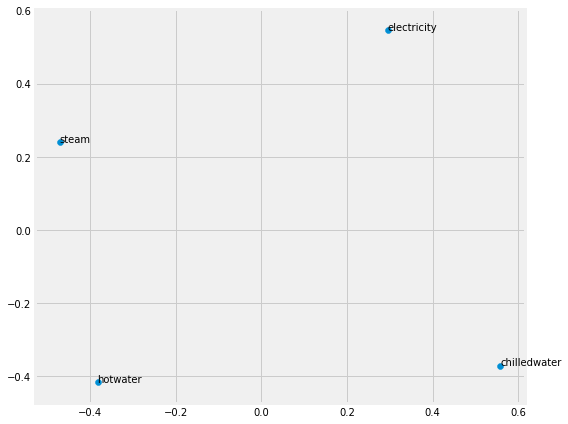

In [37]:
plot_embedding(model, encoders,'Embedding_meter', 'meter')

In [ ]:
embedding_layer = model.get_layer('Embedding_month')
weights = embedding_layer.get_weights()[0]
weights

# Submission

In [ ]:
preproc(test)
#test.shape[0]

In [55]:
max_value = 16.902212142944336

In [56]:
max_value

16.902212142944336

In [57]:
%%time
#test.head(1500000)['month'].nunique()
y_pred = np.expm1(model.predict(preproc(test)) * max_value ) [:,0]

Wall time: 15min 40s


In [58]:
y_pred.shape

(41697600,)

In [59]:
sub = pd.read_csv("C:/Users/SGAUR/Desktop/Asphare/ashrae-energy-prediction/sample_submission.csv")
sub.head()

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [60]:
%%time
sub['meter_reading'] = y_pred
sub.loc[sub['meter_reading']<0, 'meter_reading'] = 0
sub.to_csv('submission.csv', index=False)
sub

Wall time: 1min 56s


,row_id,meter_reading
0,0,0.000012
1,1,0.000000
2,2,0.000625
3,3,0.000000
4,4,0.000000
...,...,...
41697595,41697595,593.315674
41697596,41697596,334.715851
41697597,41697597,1260.478760
41697598,41697598,43670.046875


In [61]:
np.max(sub['meter_reading'])

14420829.0

In [ ]:
sub['meter_reading'].isnull().sum()

In [62]:
sub[sub['row_id']==68331]

,row_id,meter_reading
68331,68331,0.138924


In [ ]:
sub[sub['meter_reading']=='inf']